# Importing data from Excel sheet

In [16]:
import numpy as np
import pandas as pd
import datetime as datetime
import matplotlib
import time

start_time= time.time()

dateTimeObj= time.time()
price_history= pd.read_excel(r'D:\TodaysPrice\Historic_June29.xlsx', parse_dates= True)
price_history['Date']=pd.to_datetime(price_history.Date)
price_history= price_history.sort_values(by= ['Date'], ascending= True)

price_history_forRange= price_history.sort_values(by=['Date'], ascending= True)
pivot= pd.pivot_table(price_history, values= 'Closing Price', index= ['Date'], columns=['Ticker']).fillna(method='ffill')

# Price Visualization of few finance companies

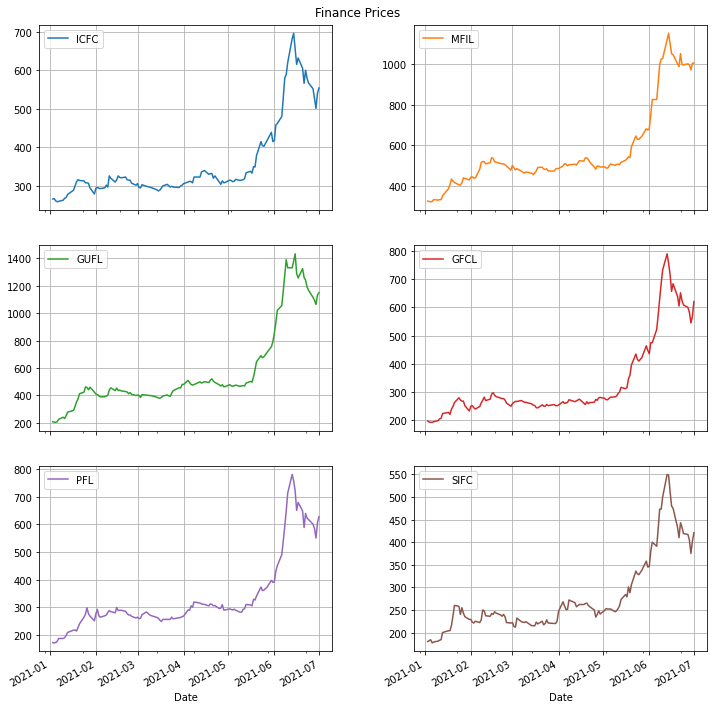

In [3]:
cols= ['ICFC', 'MFIL', 'GUFL','GFCL', 'PFL','SIFC']
pivot_finance= pivot[cols]
import matplotlib.pyplot as plt
pivot_finance.plot(subplots=True, sharex= True, layout= (3,2), title= 'Finance Prices', grid= True, figsize=(10,10))
plt.tight_layout(pad=1, w_pad=5, h_pad=3)

# Daily return on Finance Stocks in Year 2021

<BarContainer object of 6 artists>

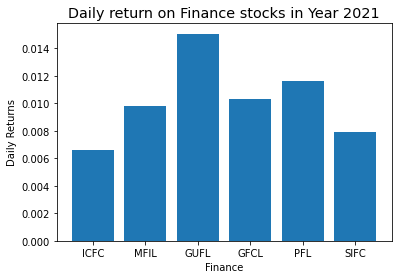

In [4]:
daily_return= pivot_finance.pct_change()
daily_return.rolling(window=20, min_periods=1).mean()
#standard deviation
daily_return.rolling(window=20).std()
daily_return.ewm(span=20, min_periods=20).mean()

fig, ax= plt.subplots()
plt.style.available
plt.style.use('ggplot')
ax.set(title= 'Daily return on Finance stocks in Year 2021', xlabel= 'Finance', ylabel= 'Daily Returns')
plt.bar(daily_return.columns, daily_return.mean())

# Obtaining cleaned data for ticker 'GFCL'

In [5]:
gfcl=(price_history['Ticker']=='GFCL')
gfcl_cluster= price_history[gfcl]
col= ['Date','Max Price', 'Min Price', 'Closing Price', 'Volume']
gfcl_clean= gfcl_cluster[col]
gfcl_clean.set_index('Date', inplace=True)
ohlcv= gfcl_clean
ohlcv

,Max Price,Min Price,Closing Price,Volume
Date,,,,
2021-01-03,198.0,192.0,198.0,4255.0
2021-01-04,198.0,194.0,194.0,9020.0
2021-01-05,196.0,192.0,193.0,3084.0
2021-01-06,196.0,193.0,193.0,1520.0
2021-01-07,196.0,193.0,195.0,5284.0
...,...,...,...,...
2021-06-27,621.0,591.0,600.0,30819.0
2021-06-28,615.0,580.0,582.0,29632.0
2021-06-29,575.0,540.0,545.0,48414.0


# Bollinger Bands

In [9]:
def BBnd(Df, n):
    #funtion to calculate ATR.
    df= Df.copy()
    df['MA']= df['Closing Price'].rolling(n).mean()
    df['BB_up']= df['MA']+2*df['MA'].rolling(n).std()
    df['BB_dn']= df['MA']-2*df['MA'].rolling(n).std()
    df['BB_range']= df['BB_up']- df['BB_dn']
    df.dropna(inplace=True)
    return df

# MACD

In [6]:
def MACD(DF, a,b,c):
    df= ohlcv.copy()
    df['MA_Fast']= df["Closing Price"].ewm(span=a, min_periods= a).mean()
    df['MA_slow']= df["Closing Price"].ewm(span=b, min_periods=b).mean()
    df['MACD']= df['MA_Fast']-df['MA_slow']
    df['signal']= df["MACD"].ewm(span=c, min_periods=c).mean()
    df.dropna(inplace=True)
    return df

# Relative Strength Index

In [10]:
def RSI(DF,n):
    "function to calculate RSI"
    df = DF.copy()
    df['delta']=df['Closing Price'] - df['Closing Price'].shift(1)
    df['gain']=np.where(df['delta']>=0,df['delta'],0)
    df['loss']=np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    return df

# Average True Range

In [12]:
def ATR(Df, n):
    #funtion to calculate ATR.
    df= Df.copy()
    df['H-L']= abs(df['Max Price']-df['Min Price'])
    df['H-PC']= abs(df['Max Price']- df['Closing Price'].shift(1))
    df['L-PC']= abs(df['Min Price']-df['Closing Price'].shift(1))
    df['TR']= df[['H-L','H-PC','L-PC']].max(axis=1, skipna=False)
    df['ATR']= df['TR'].rolling(n).mean()
    df2= df.drop(['H-L', 'H-PC', 'H-PC'], axis=1)
    return df2



# Plots

<AxesSubplot:title={'center':' GFCL Price and B-Band'}, xlabel='Date'>

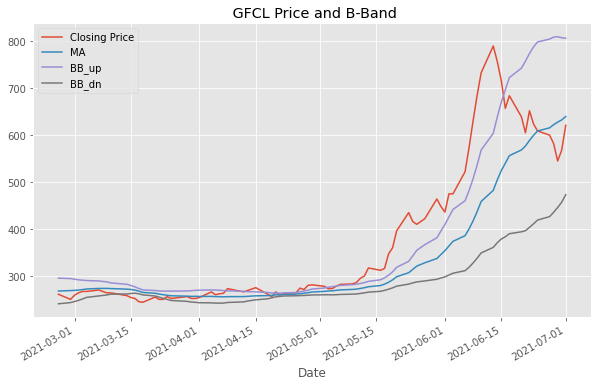

In [13]:
BBnd(ohlcv, 20).iloc[-100:, [-6,-4,-3,-2]].plot(title=' GFCL Price and B-Band', figsize= (10,6))

<AxesSubplot:title={'center':'GFCL Volume'}>

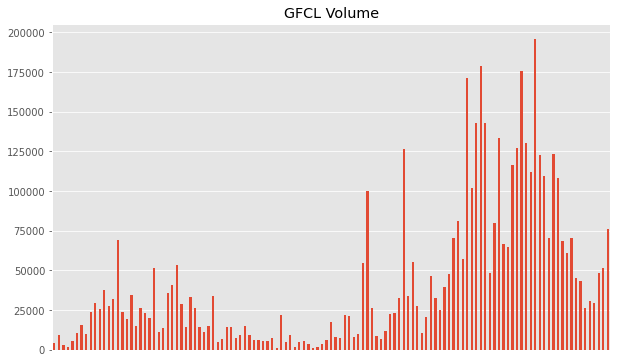

In [14]:
gfcl_cluster.iloc[:,7].plot.bar(title='GFCL Volume', xticks=[], figsize=(10,6))

<AxesSubplot:title={'center':'GFCL RSI'}, xlabel='Date'>

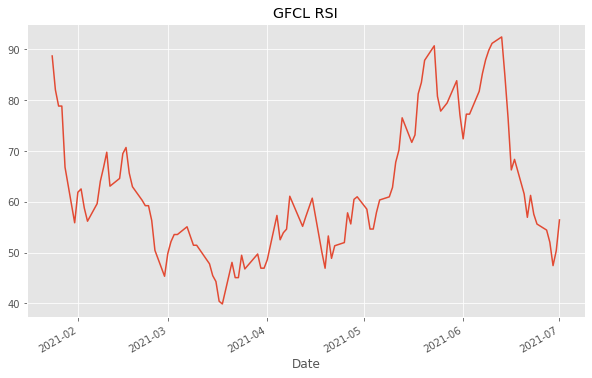

In [17]:
RSI(ohlcv, 14).iloc[:, 10].plot(title='GFCL RSI',figsize=(10,6))

<AxesSubplot:title={'center':'GFCL MACD'}, xlabel='Date'>

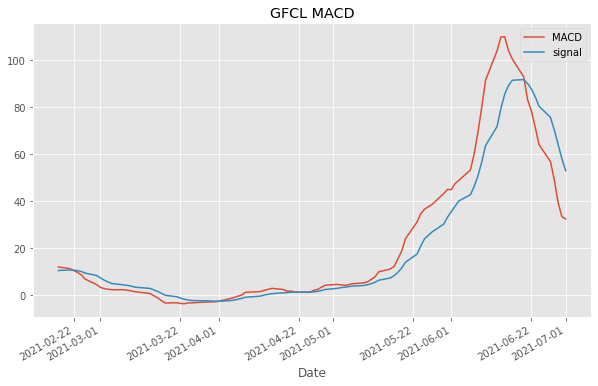

In [19]:
MACD(ohlcv, 12,26,9).iloc[:, [6,7]].plot(title='GFCL MACD', figsize=(10,6))

<AxesSubplot:title={'center':'GFCL ATR'}, xlabel='Date'>

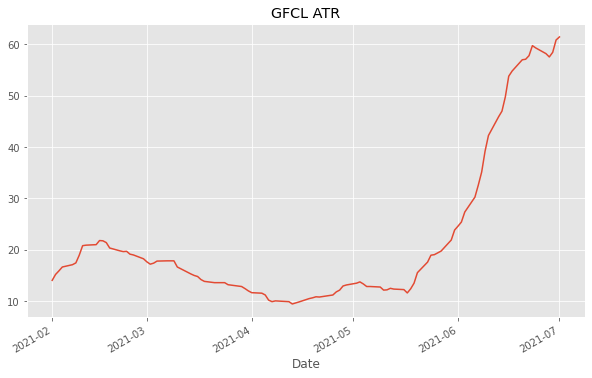

In [20]:
ATR(ohlcv, 20).iloc[:, 6].plot(title='GFCL ATR', figsize= (10,6))